<a href="https://colab.research.google.com/github/lsoica/blog/blob/main/assets/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with an LSTM Neural Network and PyTorch

In [ ]:
!pip install yfinance scikit-learn


In [24]:
import yfinance as yf
ticker = 'AMZN'
amazon_stock_data = yf.download(ticker, start="1997-05-20", end="2024-10-07")
amazon_stock_data.to_csv('AMZN.csv')

print("Data saved to AMZN.csv")

[*********************100%***********************]  1 of 1 completed

Data saved to AMZN.csv


In [25]:
import pandas as pd
data = pd.read_csv('AMZN.csv')

In [26]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
2,1997-05-22,0.071875,0.072396,0.065625,0.069792,0.069792,235536000
3,1997-05-23,0.070313,0.076042,0.066667,0.075000,0.075000,318744000
4,1997-05-27,0.075521,0.082292,0.072917,0.079167,0.079167,173952000
...,...,...,...,...,...,...,...
6885,2024-09-30,187.139999,188.490005,184.649994,186.330002,186.330002,41583900
6886,2024-10-01,184.899994,186.190002,183.449997,185.130005,185.130005,36044900
6887,2024-10-02,184.440002,186.600006,184.039993,184.759995,184.759995,23704100
6888,2024-10-03,183.050003,183.440002,180.880005,181.960007,181.960007,30204300


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [28]:
data = data[['Date', 'Close']]

In [29]:
data

,Date,Close
0,1997-05-20,0.081771
1,1997-05-21,0.071354
2,1997-05-22,0.069792
3,1997-05-23,0.075000
4,1997-05-27,0.079167
...,...,...
6885,2024-09-30,186.330002
6886,2024-10-01,185.130005
6887,2024-10-02,184.759995
6888,2024-10-03,181.960007


In [33]:
data['Date'] = pd.to_datetime(data['Date'])

/var/folders/59/c32_bthx48jd9m2ym5m3tnpw0000j7/T/ipykernel_36693/1453708669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


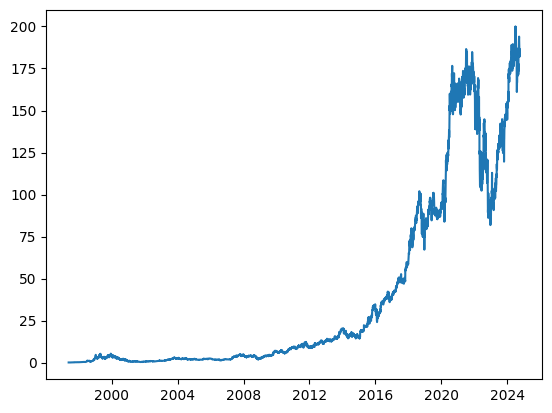

In [34]:
plt.plot(data['Date'], data['Close'])

In [35]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace = True)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)
    return df

loopback = 7
shifted_df = prepare_dataframe_for_lstm(data, loopback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792
1997-06-04,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000
1997-06-05,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167
...,...,...,...,...,...,...,...,...
2024-09-30,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005,191.600006,189.869995
2024-10-01,185.130005,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005,191.600006
2024-10-02,184.759995,185.130005,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005


In [36]:
shifted_df_as_numpy = shifted_df.to_numpy()
shifted_df_as_numpy

array([[7.50000030e-02, 7.52599984e-02, 7.65630007e-02, ...,
        6.97920024e-02, 7.13540018e-02, 8.17710012e-02],
       [7.55209997e-02, 7.50000030e-02, 7.52599984e-02, ...,
        7.50000030e-02, 6.97920024e-02, 7.13540018e-02],
       [7.39580020e-02, 7.55209997e-02, 7.50000030e-02, ...,
        7.91670009e-02, 7.50000030e-02, 6.97920024e-02],
       ...,
       [1.84759995e+02, 1.85130005e+02, 1.86330002e+02, ...,
        1.92529999e+02, 1.93960007e+02, 1.93880005e+02],
       [1.81960007e+02, 1.84759995e+02, 1.85130005e+02, ...,
        1.91160004e+02, 1.92529999e+02, 1.93960007e+02],
       [1.86509995e+02, 1.81960007e+02, 1.84759995e+02, ...,
        1.87970001e+02, 1.91160004e+02, 1.92529999e+02]])

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_numpy = scaler.fit_transform(shifted_df_as_numpy)

shifted_df_as_numpy

array([[-0.99995832, -0.99995571, -0.99994268, ..., -1.        ,
        -0.99998437, -0.99988017],
       [-0.9999531 , -0.99995832, -0.99995571, ..., -0.9999479 ,
        -1.        , -0.99998437],
       [-0.99996874, -0.9999531 , -0.99995832, ..., -0.99990622,
        -0.9999479 , -1.        ],
       ...,
       [ 0.84754595,  0.85124737,  0.86325159, ...,  0.92527391,
         0.93957898,  0.93877869],
       [ 0.81953615,  0.84754595,  0.85124737, ...,  0.91156918,
         0.92527391,  0.93957898],
       [ 0.86505215,  0.81953615,  0.84754595, ...,  0.87965802,
         0.91156918,  0.92527391]])

In [67]:
X = dc(np.flip(shifted_df_as_numpy[:, 1:], axis = 1))
y = shifted_df_as_numpy[:, 0]

In [68]:
x.shape, y.shape

((6883, 7), (6883,))

In [69]:
split_index = int(.95 * len(X))
split_index

6538

In [70]:
X_train = X[: split_index]
X_test = X[split_index :]

y_train = y[: split_index]
y_test = y[split_index :]

X_train.shape , X_test.shape , y_train.shape , y_test.shape

((6538, 7), (345, 7), (6538,), (345,))

In [71]:
X_train = X_train.reshape((-1, loopback, 1))
X_test = X_test.reshape((-1, loopback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6538, 7, 1), (345, 7, 1), (6538, 1), (345, 1))

In [72]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_train.shape , X_test.shape , y_train.shape , y_test.shape

(torch.Size([6538, 7, 1]),
 torch.Size([345, 7, 1]),
 torch.Size([6538, 1]),
 torch.Size([345, 1]))

In [73]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [74]:
from torch.utils.data import DataLoader

batchsize = 16

train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size  = len(X), shuffle  = False)

In [75]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [76]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)

torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.Size(

Create the model

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [78]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch {epoch+1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val loss: {0:.3f}'.format(avg_loss_across_batches))
    print()


In [79]:
learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch 1
Batch 100, loss: 0.842
Batch 200, loss: 0.462
Batch 300, loss: 0.216
Batch 400, loss: 0.101

Val loss: 0.364

Epoch 2
Batch 100, loss: 0.040
Batch 200, loss: 0.015
Batch 300, loss: 0.008
Batch 400, loss: 0.005

Val loss: 0.044

Epoch 3
Batch 100, loss: 0.004
Batch 200, loss: 0.003
Batch 300, loss: 0.002
Batch 400, loss: 0.002

Val loss: 0.017

Epoch 4
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.001
Batch 400, loss: 0.001

Val loss: 0.011

Epoch 5
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.000
Batch 400, loss: 0.000

Val loss: 0.007

Epoch 6
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Batch 300, loss: 0.000
Batch 400, loss: 0.000

Val loss: 0.006

Epoch 7
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Batch 300, loss: 0.000
Batch 400, loss: 0.000

Val loss: 0.004

Epoch 8
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Batch 300, loss: 0.000
Batch 400, loss: 0.000

Val loss: 0.004

Epoch 9
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Ba

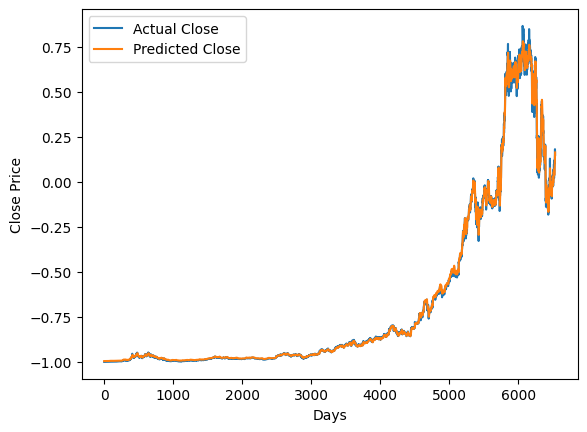

In [81]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()